# COURSE: A deep understanding of deep learning
## SECTION: FFNs
### LECTURE: FFN to classify digits
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202210

In [6]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\lucan\AppData\Local\Temp\ipykernel_5148\835761025.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Import and process the data

In [7]:
# import dataset (comes with colab!)
data = np.loadtxt(open('FFN/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

# Create train/test groups using DataLoader

In [8]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long() # long = int64

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

# Create the DL model

In [9]:
# create a class for the model
def createTheMNISTNet(nUnits, nLayers):

  class mnistNet(nn.Module):
    def __init__(self, nUnits, nLayers):
      super().__init__()

      # create dictionary to store the layers
      self.layers = nn.ModuleDict()
      self.nLayers = nLayers

      ### input layer
      self.layers['input'] = nn.Linear(784, nUnits)

      ### hidden layers
      for i in range(nLayers):
        self.layers[f'hidden{i}'] = nn.Linear(nUnits, nUnits)

      ### output layer
      self.layers['output'] = nn.Linear(nUnits, 10)

    # forward pass
    def forward(self,x):

      # input layer
      x = F.relu( self.layers['input'](x) )

      # hidden layers
      for i in range(self.nLayers):
        x = F.relu( self.layers[f'hidden{i}'](x) )

      # return output layer
      return self.layers['output'](x)
  
  # create the model instance
  net = mnistNet(nUnits, nLayers)
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(), lr=.01)

  return net,lossfun,optimizer

In [10]:
# test the model with one batch
net,lossfun,optimizer = createTheMNISTNet(3, 250)

X,y = next(iter(train_loader))
yHat = net(X)

# values are log-probability of each number (0-9)
print(torch.exp(yHat))

# now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

tensor([[1.0535, 0.6660, 1.0328, 0.6534, 0.6220, 0.6023, 0.7393, 0.6772, 0.7853,
         0.7963],
        [1.0535, 0.6660, 1.0328, 0.6534, 0.6220, 0.6023, 0.7393, 0.6772, 0.7853,
         0.7963],
        [1.0535, 0.6660, 1.0328, 0.6534, 0.6220, 0.6023, 0.7393, 0.6772, 0.7853,
         0.7963],
        [1.0535, 0.6660, 1.0328, 0.6534, 0.6220, 0.6023, 0.7393, 0.6772, 0.7853,
         0.7963],
        [1.0535, 0.6660, 1.0328, 0.6534, 0.6220, 0.6023, 0.7393, 0.6772, 0.7853,
         0.7963],
        [1.0535, 0.6660, 1.0328, 0.6534, 0.6220, 0.6023, 0.7393, 0.6772, 0.7853,
         0.7963],
        [1.0535, 0.6660, 1.0328, 0.6534, 0.6220, 0.6023, 0.7393, 0.6772, 0.7853,
         0.7963],
        [1.0535, 0.6660, 1.0328, 0.6534, 0.6220, 0.6023, 0.7393, 0.6772, 0.7853,
         0.7963],
        [1.0535, 0.6660, 1.0328, 0.6534, 0.6220, 0.6023, 0.7393, 0.6772, 0.7853,
         0.7963],
        [1.0535, 0.6660, 1.0328, 0.6534, 0.6220, 0.6023, 0.7393, 0.6772, 0.7853,
         0.7963],
        [1

# Create a function that trains the model

In [11]:
# a function that trains the model

# number of epochs
numepochs = 15

def funtion2trainTheModel(nUnits, nLayers):
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet(nUnits, nLayers)

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):
    net.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad():
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


# Run the model and show the results!

In [16]:
rows = range(1, 4)
cols = range(50, 300, 50)

test_accuracy = np.zeros((len(rows), len(cols), numepochs))
train_accuracy = np.zeros((len(rows), len(cols), numepochs))

for row_idx, row in enumerate(rows):
  for col_idx, col in enumerate(cols):
    trainAcc,testAcc,losses,net = funtion2trainTheModel(col, row)

    test_accuracy[row_idx, col_idx, :] = testAcc
    train_accuracy[row_idx, col_idx, :] = trainAcc

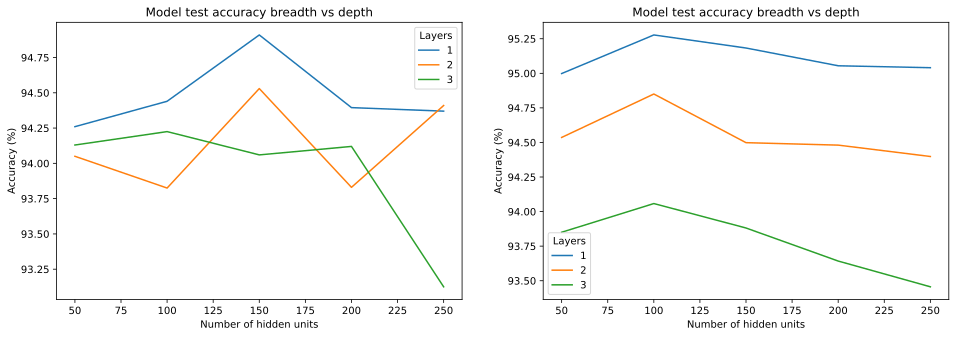

In [18]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

for row_idx, row in enumerate(rows):

  x_axis = []
  final_test_accuracies = []
  final_train_accuracies = []

  for col_idx, col in enumerate(cols):
    x_axis.append(col)

    # Take the average of the last 10 epochs
    final_test_accuracies.append(np.mean(test_accuracy[row_idx, col_idx][:-5]))
    final_train_accuracies.append(np.mean(train_accuracy[row_idx, col_idx][:-5]))

  ax[0].plot(x_axis, final_test_accuracies, label=f'{row}')
  ax[1].plot(x_axis, final_train_accuracies, label=f'{row}')

ax[0].set_title(f'Model test accuracy breadth vs depth')
ax[0].legend(title="Layers")
ax[0].set_xlabel('Number of hidden units')
ax[0].set_ylabel('Accuracy (%)')

ax[1].set_title(f'Model test accuracy breadth vs depth')
ax[1].legend(title="Layers")
ax[1].set_xlabel('Number of hidden units')
ax[1].set_ylabel('Accuracy (%)')

plt.show()